In [ ]:
# !pip install google-cloud-bigquery
# !pip install db-dtypes

In [26]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd
import os
import random
import numpy as np


In [6]:
import glob
from google.cloud import bigquery
from google.oauth2 import service_account

# 서비스 계정 키 JSON 파일 경로
key_path = glob.glob("/home/gcpwoong/project-modeling-31d4c6f20170.json")[0]

# Credentials 객체 생성
credentials = service_account.Credentials.from_service_account_file(key_path)

client = bigquery.Client(credentials = credentials, 
                         project = credentials.project_id)

# 데이터 조회 쿼리
sql_myhistory = f"""
SELECT handle user_id, tier FROM `project-modeling.dataset_temp.ranked_user_data`
"""

# 데이터 조회 쿼리 실행 결과
query_job = client.query(sql_myhistory)

# 데이터프레임 변환
user_level_df = query_job.to_dataframe()
print(user_level_df.head())


        user_id  tier
0   donggunkwak    17
1  tlatmsdlwngo    14
2      yayaja11     9
3   dmstjsdl030     9
4       sshinmj     9


In [7]:
import json
with open('/home/gcpwoong/data/lgbm_data_full/id2name.json', 'r') as f:
    id2name = json.load(f)

In [ ]:
user_level_dic={}
for i in user_level_df.values.tolist():
    user_level_dic[i[0]]=i[1]
user_level_dic

# 카테고리 미활용, train 데이터셋

In [2]:
df=pd.read_csv("/home/gcpwoong/data/lgbm_data_full/new_lgbm_data.csv")

In [10]:
df["user_id"]=df["user_id"].astype(str).map(id2name)

In [15]:
df["user_level"]=df["user_id"].astype(str).map(user_level_dic)
df

,user_id,question_id,result,submittedTimestamp,level_id,averageTries,lag_time,question_lag_time,accuracy_per_question,tag,tag_lag_time,accuracy_per_tag,cumulated_points,prior_correct_count,prior_count,prior_accuracy,prior_tag_correct_count,prior_tag_count,prior_tag_accuracy,user_level
0,000000,2557,1,1660030281,1,2,0,0,72,923,0,73,0,0,0,0,0,0,0,3
1,000000,7287,1,1660030387,1,1,106,0,60,923,106,73,28,1,1,100,1,1,100,3
2,000000,10172,1,1660031212,1,2,825,0,59,923,825,73,68,2,2,100,2,2,100,3
3,000000,10699,1,1660031392,1,1,180,0,64,923,180,73,109,3,3,100,3,3,100,3
4,000000,10171,1,1660031619,1,3,227,0,61,923,227,73,145,4,4,100,4,4,100,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23999519,zzzzzzzzu2,15663,1,1665124657,9,2,64612,0,71,2202,219725,78,1456,60,63,95,1,6,17,6
23999520,zzzzzzzzu2,1182,1,1665316270,9,2,191613,0,55,3229,256225,67,1485,61,64,95,0,1,0,6
23999521,zzzzzzzzu2,1759,0,1665402290,11,2,86020,0,58,1782,0,58,1530,62,65,95,0,0,0,6
23999522,zzzzzzzzu2,1759,1,1665402978,11,2,688,688,58,1782,688,58,1472,62,66,94,0,1,0,6


In [16]:
df.to_csv("/home/gcpwoong/data/lgbm_data_full/new_lgbm_data.csv",index=False)

In [7]:
df.head(10)

,user_id,question_id,result,submittedTimestamp,level_id,averageTries
0,ggoh,8876,0,1655873731,22,5.4375
1,jhhope1,17625,0,1583946550,24,3.7857
2,taejin1221,2261,0,1594129301,19,6.2355
3,mial1111,5615,0,1674747209,20,5.1204
4,chldntjr1211,2419,0,1546435859,20,3.1259
6,cakelemon,1873,0,1539015235,21,9.5714
7,kng0258,13705,0,1628831831,21,26.7703
8,jeong,5651,0,1484677809,20,3.5603
9,james6446,17405,0,1665905541,27,3.3889
10,jhuni,11479,0,1656326869,19,2.2379


# LGBM을 활용한 베이스라인

## 1. 데이터 로딩

## 2. Feature Engineering

In [10]:
# def feature_engineering(df):
    
#     #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
#     df=df.astype({"averageTries":"int"})
#     df.sort_values(by=['user_id','submittedTimestamp'], inplace=True)
#     df["prior_question_elapsed_time"]=df.groupby(["user_id"])["submittedTimestamp"].diff().fillna(0)
#     df=df.astype({"prior_question_elapsed_time":"int"})
#     df["user_correct_answer"]=df.groupby(['user_id'])['result'].transform(lambda x: x.cumsum().shift(1)).fillna(0).astype(int)
#     df['user_total_answer'] = df.groupby('user_id')['user_id'].cumcount()

#     df = df.sort_values(by=["user_id", "question_id","submittedTimestamp"])
#     df["user_tries_per_question"] = df.groupby(["user_id", "question_id"]).cumcount()
#     df = df.sort_values(by=["user_id","submittedTimestamp"])
#     df=df.drop(columns=["submittedTimestamp"])
    

    
#     return df

In [6]:
# def feature_engineering(df):
    
#     #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
#     df.sort_values(by=['user_id','submittedTimestamp'], inplace=True)
    
#     #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
#     # df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
#     # df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
#     # df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

#     # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
#     # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
#     # correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
#     # correct_t.columns = ["test_mean", 'test_sum']
#     # correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
#     # correct_k.columns = ["tag_mean", 'tag_sum']

#     # df = pd.merge(df, correct_t, on=['testId'], how="left")
#     # df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    
#     return df

In [ ]:
# def feature_engineering(df):
    
#     #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
#     df.sort_values(by=['userID','Timestamp'], inplace=True)
    
#     #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
#     df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
#     df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
#     df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

#     # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
#     # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
#     correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
#     correct_t.columns = ["test_mean", 'test_sum']
#     correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
#     correct_k.columns = ["tag_mean", 'tag_sum']

#     df = pd.merge(df, correct_t, on=['testId'], how="left")
#     df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    
#     return df

## 3. Train/Test 데이터 셋 분리

In [17]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.9, split=True):
    
    users = list(zip(df['user_id'].value_counts().index, df['user_id'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['user_id'].isin(user_ids)]
    test = df[df['user_id'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    # test = test[test['user_id'] != test['user_id'].shift(-1)]
    return train, test

In [18]:
train, test = custom_train_test_split(df)

# train/valid 분리

In [19]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_valid_split(df, ratio=0.7, split=True):
    
    users = list(zip(df['user_id'].value_counts().index, df['user_id'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['user_id'].isin(user_ids)]
    valid = df[df['user_id'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    valid = valid[valid['user_id'] != valid['user_id'].shift(-1)]
    return train, valid

In [7]:
df

,user_id,question_id,result,submittedTimestamp,level_id,averageTries,lag_time,question_lag_time,accuracy_per_question,tag,tag_lag_time,accuracy_per_tag,cumulated_points,prior_correct_count,prior_count,prior_accuracy,prior_tag_correct_count,prior_tag_count,prior_tag_accuracy
0,0,2557,1,1660030281,1,2,0,0,72,923,0,73,0,0,0,0,0,0,0
1,0,7287,1,1660030387,1,1,106,0,60,923,106,73,28,1,1,1,1,1,100
2,0,10172,1,1660031212,1,2,825,0,59,923,825,73,68,2,2,1,2,2,100
3,0,10699,1,1660031392,1,1,180,0,64,923,180,73,109,3,3,1,3,3,100
4,0,10171,1,1660031619,1,3,227,0,61,923,227,73,145,4,4,1,4,4,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23987454,79526,15663,1,1665124657,9,2,64612,0,71,2202,219725,78,1456,60,63,0,1,6,17
23987455,79526,1182,1,1665316270,9,2,191613,0,55,3229,256225,67,1485,61,64,0,0,1,0
23987456,79526,1759,0,1665402290,11,2,86020,0,58,1782,0,58,1530,62,65,0,0,0,0
23987457,79526,1759,1,1665402978,11,2,688,688,58,1782,688,58,1472,62,66,0,0,1,0


In [20]:
# 유저별 분리
train, valid = custom_train_test_split(train)

# FEATS = ["question_id","level_id",
#          "averageTries","lag_time","accuracy_per_question","tag","accuracy_per_tag",
#          "cumulated_points","prior_correct_count","prior_accuracy","prior_tag_correct_count"
#          ,"prior_tag_accuracy","question_lag_time","tag_lag_time"]



FEATS = ["question_id","level_id",
         "averageTries","lag_time","accuracy_per_question","tag","accuracy_per_tag",
         "cumulated_points","prior_correct_count","prior_count","prior_accuracy","prior_tag_correct_count",
         "prior_tag_count","prior_tag_accuracy","user_level"]
# 사용할 Feature 설정

# X, y 값 분리
y_train = train['result']
train = train.drop(['result'], axis=1)

y_valid = valid['result']
valid = valid.drop(['result'], axis=1)

In [37]:
# FEATS = ["question_id","level_id",
#          "averageTries","lag_time","accuracy_per_question","tag","accuracy_per_tag",
#          "cumulated_points","prior_correct_count","prior_accuracy","prior_tag_correct_count"
#          ,"prior_tag_accuracy","question_lag_time","tag_lag_time"]

In [17]:
# !pip install lightgbm
# !pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to 

In [21]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np


In [22]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_valid = lgb.Dataset(valid[FEATS], y_valid)

In [23]:
del df

## 4. 훈련 및 검증

In [24]:
model = lgb.train(
    {'objective': 'binary'}, 
    lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    verbose_eval=100,
    num_boost_round=700,
    early_stopping_rounds=100
)


/home/gcpwoong/.local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/gcpwoong/.local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 11454025, number of negative: 7985358
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.481503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 19439383, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.589218 -> initscore=0.360732
[LightGBM] [Info] Start training from score 0.360732
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.550893	valid_1's binary_logloss: 0.55699
[200]	training's binary_logloss: 0.54883	valid_1's binary_logloss: 0.555082
[300]	training's binary_logloss: 0.547779	valid_1's binary_logloss: 0.554164
[400]	training's binary_logloss: 0.547063	valid_1's binary_logloss: 0.553596
[500]	training's binary_logloss: 0.546514	valid_1's binary_loglos

In [25]:
import pickle
file = 'new_trained_model2.pkl'
pickle.dump(model, open(file, 'wb'))
print('Trained LGB model was saved!')

Trained LGB model was saved!


In [26]:
preds = model.predict(valid[FEATS])
acc = accuracy_score(y_valid, np.where(preds >= 0.51, 1, 0))
auc = roc_auc_score(y_valid, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

VALID AUC : 0.771058602596776 ACC : 0.7075249252877953



In [14]:
# preds = model.predict(valid[FEATS])
# acc = accuracy_score(y_valid, np.where(preds >= 0.51, 1, 0))
# auc = roc_auc_score(y_valid, preds)

# print(f'VALID AUC : {auc} ACC : {acc}\n')

VALID AUC : 0.7780418771119205 ACC : 0.7115294074075789



In [ ]:
# INSTALL MATPLOTLIB IN ADVANCE
# _ = lgb.plot_importance(model)

## 5. Inference

In [26]:
test.head(5)

,user_id,question_id,result,level_id,averageTries,prior_question_elapsed_time,user_correct_answer,user_total_answer,user_tries_per_question
9571324,1,2557,1,1,2,0,0,0,0
4761257,1,1008,1,1,2,12,4,4,0
7783387,1,10816,1,7,2,14,124,183,5
23361529,1,1920,1,7,3,16,118,170,1
23232601,1,10815,1,6,2,16,120,172,1


In [27]:
# LOAD TESTDATA
# test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
# test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
# test_df = feature_engineering(test)
test_df=test
# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['user_id'] != test_df['user_id'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['result'], axis=1)

In [28]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [27]:
len(total_preds)

8265

In [28]:
len(test_df)

8265

In [24]:
test_df

,user_id,question_id,submittedTimestamp,level_id,averageTries,lag_time,question_lag_time,accuracy_per_question,tag,tag_lag_time,accuracy_per_tag,cumulated_points,prior_correct_count,prior_count,prior_accuracy,prior_tag_correct_count,prior_tag_count,prior_tag_accuracy
2433,5,9093,1648146436,5,1,46526,0,76,3629,57878300,64,-2054,187,340,0,2,2,100
2939,8,1987,1658497367,12,3,2831,37522972,57,4500,37522972,57,-4637,177,381,0,0,2,0
3524,13,2018,1648431288,6,2,3066,3066,63,1633,3066,63,-2950,44,107,0,0,2,0
3629,14,17298,1667720027,12,3,4968549,0,62,2643,0,64,-987,60,104,0,0,0,0
4761,19,1269,1664093002,7,1,607265,0,84,1898,0,82,875,122,168,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23982343,79503,1676,1624938775,6,2,2341244,0,57,1174,0,55,-1362,44,88,0,0,0,0
23983018,79508,10172,1666608330,1,2,33727151,37638278,59,923,37476035,73,-3593,22,88,0,5,17,29
23985575,79517,1707,1653125360,12,4,24635,24635,41,3861,24635,41,-4238,259,495,0,0,2,0
23987109,79523,10871,1635691333,1,1,854,0,79,923,854,73,-222,27,41,0,10,11,91


In [29]:
# true_test = feature_engineering(test)
true_test=test
# LEAVE LAST INTERACTION ONLY
true_test = true_test[true_test['user_id'] != true_test['user_id'].shift(-1)]
true_test

,user_id,question_id,result,submittedTimestamp,level_id,averageTries,lag_time,question_lag_time,accuracy_per_question,tag,tag_lag_time,accuracy_per_tag,cumulated_points,prior_correct_count,prior_count,prior_accuracy,prior_tag_correct_count,prior_tag_count,prior_tag_accuracy,user_level
1794,000000hj,9095,0,1674135211,8,1,201,201,80,972,201,54,-549,91,137,66,0,5,0,6
2939,0021,1987,1,1658497367,12,3,2831,37522972,57,4500,37522972,57,-4637,177,381,46,0,2,0,11
4369,00choiyewon00,2751,1,1646908492,6,3,186519,0,76,594,0,73,749,54,70,77,0,0,0,6
13956,0176778602,10830,1,1655957329,12,2,4821965,18279009,48,1434,18279009,48,-157,79,159,50,0,2,0,10
14264,01bjy,1697,0,1675321198,10,3,1427,1427,52,656,1427,52,-4728,152,307,50,0,5,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23988096,zzrlfla,2004,1,1642920448,9,3,88,88,51,3401,88,57,-63,99,160,62,1,5,20,9
23989238,zzudy1100,1365,1,1647069324,14,1,1471323,0,72,3821,0,60,558,19,21,90,0,0,0,3
23991221,zzz010zz,18108,1,1666679112,1,1,213,3015804,85,2273,2325337,62,-425,41,65,63,12,14,86,3
23994114,zzz845zz,1516,1,1600481400,13,2,2435,0,59,53,49965872,60,1305,358,579,62,7,7,100,13


In [31]:
# def rounding(x):
#     if x>0.51:
#         x=1
#     else:
#         x=0
#     return x
# test_df["predicted_result"]=list(map(rounding, total_preds))
# test_df

,user_id,question_id,level_id,averageTries,prior_question_elapsed_time,user_correct_answer,user_total_answer,user_tries_per_question,predicted_result
23350181,1,2960,7,1,5529875,129,188,0,1
21684194,9,10718,1,1,131840120,1,1,0,1
19412330,34,10818,3,2,24949205,55,103,1,1
4175078,44,11399,7,1,10600050,3,7,0,1
10112797,63,2839,7,2,48781174,1,2,0,0
...,...,...,...,...,...,...,...,...,...
3924178,40033,2292,4,2,39190937,3,4,0,0
2382624,40057,2557,1,2,45616937,10,28,0,1
4362204,40064,14888,10,2,5077455,168,226,0,1
12224867,40089,10250,3,3,16965962,1,1,0,0


In [30]:
def rounding(x):
    if x>0.52:
        x=1
    else:
        x=0
    return x

a=true_test["result"].tolist()
b=list(map(rounding, total_preds))

cnt=0
for i in range(len(a)):
    if a[i]==b[i]:
        cnt+=1
cnt/len(a)


0.6780009680542111

In [22]:
len(test_df)
len(total_preds)


8265

In [19]:
from collections import defaultdict

distribution=defaultdict(int)

for i in total_preds:
    if i>0.9:
        distribution["0.9+"]+=1
    elif 0.8<i<=0.9:
        distribution["0.8~0.9"]+=1
    elif 0.7<i<=0.8:
        distribution["0.7~0.9"]+=1
    elif 0.6<i<=0.7:
        distribution["0.6~0.7"]+=1
    elif 0.51<i<=0.6:
        distribution["0.51~0.6"]+=1
    elif 0.4<i<=0.51:
        distribution["0.4~0.51"]+=1
    elif 0.3<i<=0.4:
        distribution["0.3~0.4"]+=1
    elif 0.2<i<=0.3:
        distribution["0.2~0.3"]+=1
    else:
        distribution["0.0~0.2"]+=1
for k,v in distribution.items():
    distribution[k]=round((v/len(total_preds)),4)*100
distribution

defaultdict(int,
            {'0.9+': 6.65,
             '0.4~0.51': 13.930000000000001,
             '0.3~0.4': 9.19,
             '0.0~0.2': 1.8499999999999999,
             '0.8~0.9': 15.68,
             '0.7~0.9': 16.38,
             '0.51~0.6': 14.219999999999999,
             '0.6~0.7': 16.8,
             '0.2~0.3': 5.29})

In [38]:
import pickle
# file = 'trained_model1.pkl'
# pickle.dump(model, open(file, 'wb'))
# print('Trained LGB model was saved!')

with open('trained_model2.pkl', 'rb') as f: 
    model = pickle.load(f)

In [35]:
FEATS = ["question_id","level_id",
         "averageTries","lag_time","accuracy_per_question","tag","accuracy_per_tag",
         "cumulated_points","prior_correct_count","prior_count","prior_accuracy","prior_tag_correct_count",
         "prior_tag_count","prior_tag_accuracy"]

[Text(0.5, 1.0, 'Feature Importance (gain)'),
 Text(0.5, 0, 'Feature Importance'),
 Text(0, 0.5, 'Features')]

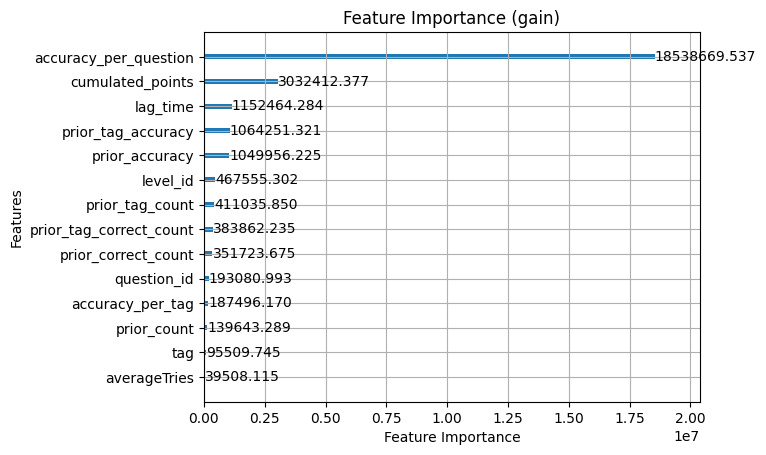

In [20]:
ax = lgb.plot_importance(model, max_num_features=len(FEATS), importance_type='gain')
ax.set(title=f'Feature Importance (gain)',
	xlabel='Feature Importance',
	ylabel='Features')
# ax.figure.savefig(f'{PATH}/fi_gain).png', dpi=300)

In [40]:
import eli5
from eli5.sklearn import PermutationImportance

In [44]:

perm = PermutationImportance(model, random_state=1).fit(valid[FEATS], y_valid)
eli5.show_weights(perm, feature_names = valid[FEATS].columns.tolist())

TypeError: estimator should be an estimator implementing 'fit' method, <lightgbm.basic.Booster object at 0x7f73084d5760> was passed

In [ ]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

In [23]:
df1=pd.read_csv("/home/gcpwoong/data/train_data.csv")
df2=pd.read_csv("/home/gcpwoong/data/test_data.csv")


In [26]:
set1=set(df1.userID.unique())
set2=set(df2.userID.unique())

In [29]:
set1&set2

set()

In [32]:
test_df

,historyId,user_id,question_id,submittedTimestamp,rnk,predicted_result
2976682,52861109,0,1000,1671519435,2,1
2978637,25816861,3,2292,1611916486,2,1
2979150,53742413,6,1157,1673196946,2,1
2980150,41094051,13,2018,1648428222,2,1
2981559,39224949,20,11557,1645097216,2,1
...,...,...,...,...,...,...
21085099,53194332,79479,1011,1672235552,2,1
21086484,53035426,79489,1152,1671888272,2,0
21087449,49959762,79492,2785,1664640475,2,1
21091683,46775242,79509,16435,1658933069,2,1


: 